## Advection equation using SBP Operators

Let us solve the one-dimensional advection equation with periodic boundary conditions
$$
u_t + c u_x = 0\;\; \text{on }[a,b], \\
c>0, \\
u(x,0)=u_0(x), \\
u(a,t)=u(b,t).
$$

Importing some libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from basis_nodes import generate_lagrange_poly, generate_LGL_points
from SBP_matrices import first_order_D, first_order_P_Q

Defining parameters

In [46]:
#Computational domain
#Each element i will be enclosed by x_{i} and x_{i+1}
x = np.linspace(0,2*np.pi,10)
n_elements = len(x)-1
#Advection speed
c = 0.5
#Spatial order of accuracy
order_x = 3

Computing nodes at reference element

In [47]:
#We'll need a Lagrange basis of degree order_x-1
#Thus, we will need order_x nodes in each element
degree_basis = order_x-1
(p_Legn, p_Legn_prime,
p_Legn1, p_Legn1_prime,
x_LG, w_LG,
x_LGL, w_LGL) = generate_LGL_points(degree_basis)
n_nodes = len(x_LGL)

Mapping reference element to whole grid. The interface points are stored twice for simplicity.

In [49]:
#We map the nodes from the reference element to one of the elements 
#from our computational domain (this suffices since we are using an uniform grid)
x_min = x[0]
x_max = x[1]
x_element = (x_LGL*(x_max-x_min)+(x_min+x_max))/2

#We define our grid (interface points will be repeated)
x_grid = np.zeros(n_elements*n_nodes)
for i in range(n_elements): 
    j = i*n_nodes
    x_grid[j:j+n_nodes] = x_element+x[i]
    print(f"Element {i+1:}\t {x_grid[j:j+n_nodes]}")
#print(x_grid)
#print(x)

Element 1	 [0.         0.34906585 0.6981317 ]
Element 2	 [0.6981317  1.04719755 1.3962634 ]
Element 3	 [1.3962634  1.74532925 2.0943951 ]
Element 4	 [2.0943951  2.44346095 2.7925268 ]
Element 5	 [2.7925268  3.14159265 3.4906585 ]
Element 6	 [3.4906585  3.83972435 4.1887902 ]
Element 7	 [4.1887902  4.53785606 4.88692191]
Element 8	 [4.88692191 5.23598776 5.58505361]
Element 9	 [5.58505361 5.93411946 6.28318531]


Setting initial conditions:
$
u(x,0) = \sin(x).
$

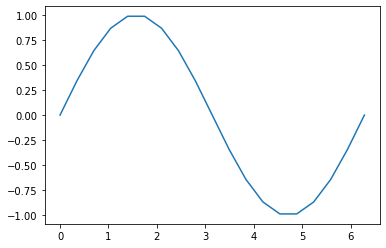

In [53]:
u = np.sin(x_grid)
plt.plot(x_grid,u)
plt.show()

Obtaining local relevant SBP matrices and resizing them over the whole grid with Kronecker products

In [87]:
#Local matrices
P_LGL, Q_LGL = first_order_P_Q(x_Lagrange_nodes=x_LGL)

#Global matrices
P = np.kron(np.eye(9), P_LGL)
for i in range(len(P[0])):
    for j in range(len(P)):
        print(np.round(P[i,j],1),end=' ')
    print("")
np.shape(P)

0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 1.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0

(27, 27)